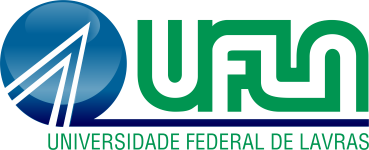

# Parallel Simulated Annealing

Trabalho Final da disciplina **Programação Paralela e Concorrente** (2023/1).


**Professora:** Marluce Rodrigues Pereira

**Alunos:**

- João Gabriel Kondarzewski Zanella - 202020091
- Henrique Curi de Miranda - 202020087
- Victor Gonçalves Lima - 202020775

O trabalho tem como objeto paralelizar o algorimo de otimização ***Simulated Annealing*** e analizar os resutados obtidos.

## Importações

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from src.funcoes_registro import carregar_populacao, carregar_solucao_inicial, carregar_parametros_populacao, carregar_cpu_info, carregar_experimentacao, carregar_algoritmos
from src.funcoes_plotagem import plotar_itens

## Dispersão dos itens

In [2]:
parametros_populacao = carregar_parametros_populacao("./parametros_iniciais/")

parametros_populacao

{'numero_itens': 10000,
 'valor_minimo': 1,
 'valor_maximo': 5,
 'tipo_valor': 'int',
 'peso_minimo': 10.0,
 'peso_maximo': 1000.0,
 'tipo_peso': 'float'}

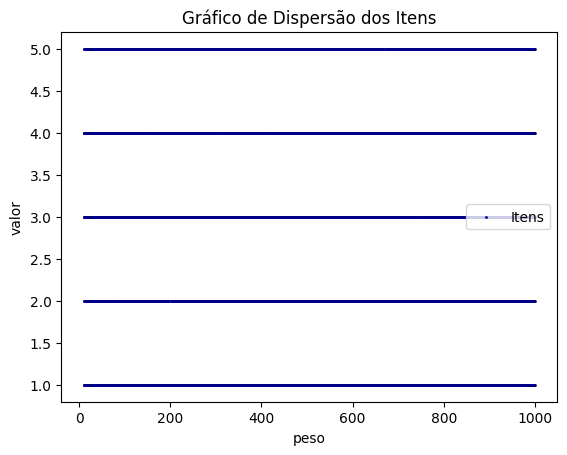

In [3]:
itens = carregar_populacao("./parametros_iniciais/")

plotar_itens(itens)

## Solução aleatória

Total de itens na mochila: 22
Valor total na mochila: 67
Peso total na mochila: 9989.963056240924


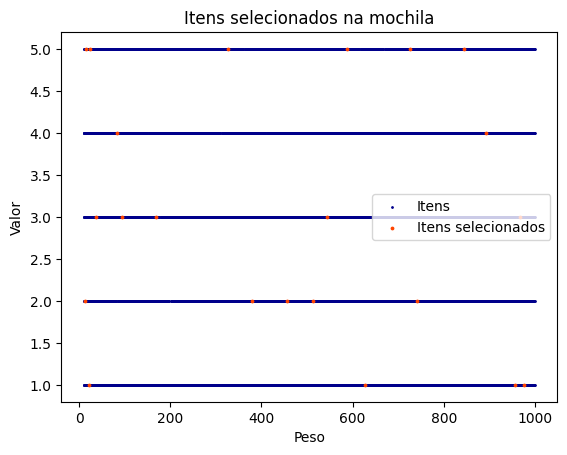

In [4]:
capacidade_das_mochilas = 10000.0 # 10 toneladas
mochila_inicial = carregar_solucao_inicial("./parametros_iniciais/", itens)
plotar_itens(itens, mochila_inicial)

## Funções para prepação dos dados

In [5]:
def carregar_execucoes(parametros_experimentacao, diretorio):
    execucoes = {}
    processes_numbers = parametros_experimentacao["processes_number"]
    numero_execucoes = parametros_experimentacao["numero_execucoes"]
    for i in processes_numbers:
        execucoes[f"psa{i}"] = {"run_times": [],
                                 "final_value": []}
        for j in range(numero_execucoes):
            f = open(f"{diretorio}run-PSA{i}-{j}.json")
            j = json.load(f)
            execucoes[f"psa{i}"]["run_times"].append(j["execution_time"])
            execucoes[f"psa{i}"]["final_value"].append(j["value"][-1])
    return execucoes

## Funções para cálculos estatísticos

## Funções para análises estatísticas

### Desvio padrão

O desvio padrão é definido como:

$$\sigma = \sqrt{\frac{ \sum(x_i - \mu)^2}{N}}$$

onde $N$ é o tamanho da população, $x_i$ é cada valor da população e $\mu$ é a média aritmética da população.

### Intervalo de confiança

O intervalo de confiança pode é definido como:

$$CI = \bar{x} \pm z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

onde $\bar{x}$ é a média da amostra, $z_{\frac{\alpha}{2}}$ é o valor crítico para a distribuição normal padrão correspondente a um nível de confiança de $1-\alpha$, $\sigma$ é o desvio padrão da população, e $n$ é o tamanho da amostra.

Para um intervalo de confiança de 95%, será:

$$CI = \bar{x} \pm 1.96 \frac{\sigma}{\sqrt{n}}$$

In [6]:
def media_aritmetica(populacao): 
    return sum(populacao) / len(populacao)

def desvio_padrao(populacao):
    media = media_aritmetica(populacao)
    soma_dos_quadrados = sum((x - media) ** 2 for x in populacao)
    return (soma_dos_quadrados / len(populacao)) ** 0.5

def intervalo_confianca(populacao):
    media = media_aritmetica(populacao)
    desvio = desvio_padrao(populacao)
    margem_de_erro = 1.96 * desvio / (len(populacao) ** 0.5)
    return margem_de_erro

## Funções para exibição dos resultados

In [13]:
def display_execucoes(execucoes):
    display(pd.concat([pd.DataFrame(execucoes[k]) for k in execucoes.keys()],
                      axis=1, keys=execucoes.keys()))
    
def plotar_tempos_execucao(execucoes):
    fig, ax = plt.subplots()
    for key in execucoes:
        ax.plot(execucoes[key]['run_times'], label=key)
    ax.set_xlabel('Execução')
    ax.set_ylabel('Tempo de Execução (segundos)')
    ax.set_ylim(0)
    ax.set_xlim(0, len(execucoes[next(iter(execucoes))]["run_times"]) - 1)
    ax.legend()
    plt.title("Tempo de Execução por Execução")
    plt.show()
    
def plotar_valores_finais(execucoes):
    fig, ax = plt.subplots()
    for key in execucoes:
        ax.plot(execucoes[key]['final_value'], label=key)
    ax.set_xlabel('Execução')
    ax.set_ylabel('Valor final da mochila')
    ax.set_ylim(0)
    ax.set_xlim(0, len(execucoes[next(iter(execucoes))]["run_times"]) - 1)
    ax.legend()
    plt.title("Valor Final da Mochila por Execução")
    plt.show()

def calcular_media_tempo_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["run_times"])
        me = intervalo_confianca(execucoes[k]["run_times"])
        media[k] = (ma, me)
    return media

def display_media_tempos(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_tempo_com_erro(execucoes)
    df = {}
    for k in media.keys():
        df[k] = {"media": media[k][0],
                 "margem_erro": media[k][1]}
    display(pd.DataFrame(df))

def plotar_media_tempos(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_tempo_com_erro(execucoes)
    x, y = [], []
    for k in media.keys():
        x.append(media[k][0])
        y.append(media[k][1])
    fig, ax = plt.subplots()
    plt.plot(threads, x)
    plt.errorbar(threads, x, yerr=y, fmt='none', capsize=10)
    plt.fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='r', alpha=.5)
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Tempo médio de execução (segundos)')
    ax.set_ylim(0, x[-1] + y[-1] * 10)
    ax.set_xlim(0, threads[-1])
    plt.title("Tempo de Execução por Thread (Intervalo de Confiança de 95%)")
    plt.show()
    
def calcular_media_valor_com_erro(execucoes):
    media = {}
    for k in execucoes.keys():
        ma = media_aritmetica(execucoes[k]["final_value"])
        me = intervalo_confianca(execucoes[k]["final_value"])
        media[k] = (ma, me)
    return media

def display_media_valores(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_valor_com_erro(execucoes)
    df = {}
    for k in media.keys():
        df[k] = {"media": media[k][0],
                 "margem_erro": media[k][1]}
    display(pd.DataFrame(df))
    
def plotar_media_valores(execucoes):
    threads = [k[3:] for k in execucoes.keys()]
    media = calcular_media_valor_com_erro(execucoes)
    x, y = [], []
    for k in media.keys():
        x.append(media[k][0])
        y.append(media[k][1])
    fig, ax = plt.subplots()
    plt.plot(threads, x)
    plt.errorbar(threads, x, yerr=y, fmt='none', capsize=10)
    plt.fill_between(threads, [i-k for i, k in zip(x, y)], [i+k for i, k in zip(x, y)], color='r', alpha=.5)
    ax.set_xlabel('Número de threads')
    ax.set_ylabel('Valor Final na Mochila')
    ax.set_ylim(0, x[-1] + y[-1] * 10)
    ax.set_xlim(0, threads[-1])
    plt.title("Valor Final por Thread (Intervalo de Confiança de 95%)")
    plt.show()
    
def exibir_resultados_execucoes(execucoes):
    print("Resultados:")
    display_execucoes(execucoes)
    plotar_tempos_execucao(execucoes)
    plotar_valores_finais(execucoes)
    display_media_tempos(execucoes)
    plotar_media_tempos(execucoes)
    display_media_valores(execucoes)
    plotar_media_valores(execucoes)

## Análises

### Análise 1

In [14]:
DIRETORIO_DATA_100 = "./data/notebook_i5_100/"
DIRETORIO_DATA_1000 = "./data/notebook_i5_1000/"
DIRETORIO_DATA_10000 = "./data/notebook_i5_10000/"

In [15]:
cpu_info = carregar_cpu_info(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)

print("Versão do Python:", cpu_info["python_version"])
print("Hardware da CPU:", cpu_info["brand_raw"])
print("Número de threads disponíveis:", cpu_info["count"])
print()
print("Número de threads utilizadas:", parametros_experimentacao["processes_number"])
print("Número de execuções por thread:", parametros_experimentacao["numero_execucoes"])
print()
print("Parâmetros do algoritmo:")
print("Temperatura inicial:", parametros_algoritmo["temperatura_inicial"])
print("Temperatura final:", parametros_algoritmo["temperatura_final"])
print("Taxa de resfriamento:", parametros_algoritmo["taxa_resfriamento"])

Versão do Python: 3.10.6.final.0 (64 bit)
Hardware da CPU: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
Número de threads disponíveis: 8

Número de threads utilizadas: [1, 2, 4, 8, 16]
Número de execuções por thread: 10

Parâmetros do algoritmo:
Temperatura inicial: 1
Temperatura final: 0.1
Taxa de resfriamento: 0.01


Número de vizinhos explorados: 100
Resultados:


psa1                  psa2                  psa4                  psa8  \
  run_times final_value run_times final_value run_times final_value run_times   
0  4.044174         706  4.123683         699  4.663251         645  6.321043   
1  4.160810         702  4.089340         678  4.777537         695  6.419170   
2  4.328833         705  4.099600         684  4.687732         665  6.270398   
3  4.266247         711  4.148254         720  4.732279         690  6.248035   
4  4.267458         698  4.125139         725  4.698247         679  6.330266   
5  4.226179         660  4.029595         663  4.849244         719  6.276807   
6  4.275882         702  4.166130         695  4.710735         691  6.283009   
7  4.228222         698  4.057688         713  4.841761         701  6.205854   
8  4.377928         719  4.427462         727  4.677266         675  6.387965   
9  4.254043         692  4.218026         693  4.739103         670  6.219311   

                  psa16              
  final_value run_times final_value  
0         686  9.419147         687  
1         688  9.383012         704  
2         718  9.387505         716  
3         719  9.364698         685  
4         677  9.274371         701  
5         738  9.517527         716  
6         696  9.517398         738  
7         682  9.303747         692  
8         668  9.397130         671  
9         692  9.269533         666

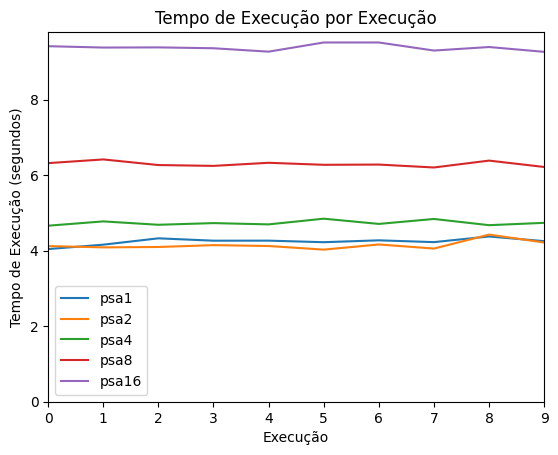

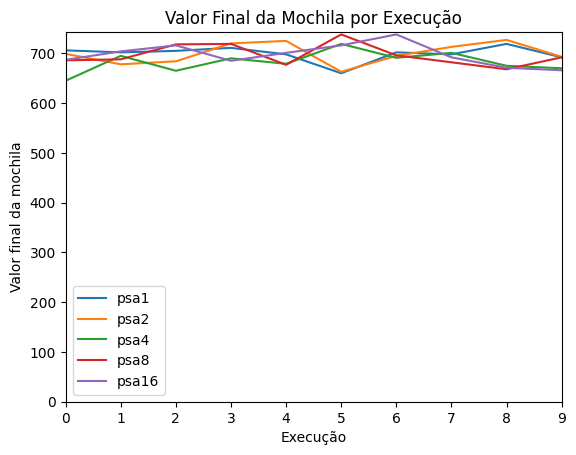

,psa1,psa2,psa4,psa8,psa16
media,4.242977,4.148492,4.737716,6.296186,9.383407
margem_erro,0.053570,0.065712,0.038640,0.040610,0.051476


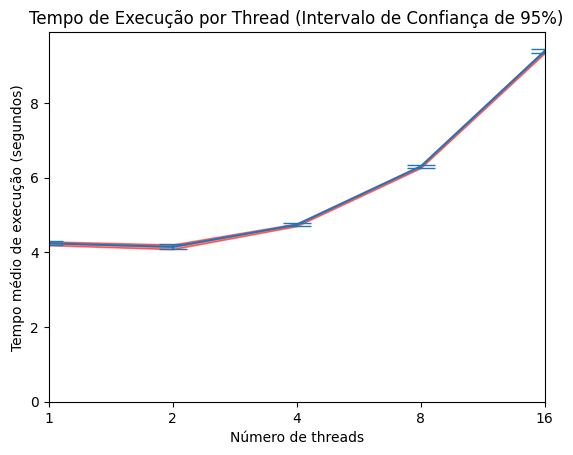

,psa1,psa2,psa4,psa8,psa16
media,699.300000,699.700000,683.000000,696.400000,697.600000
margem_erro,9.230955,12.559456,12.230777,12.847198,12.957364


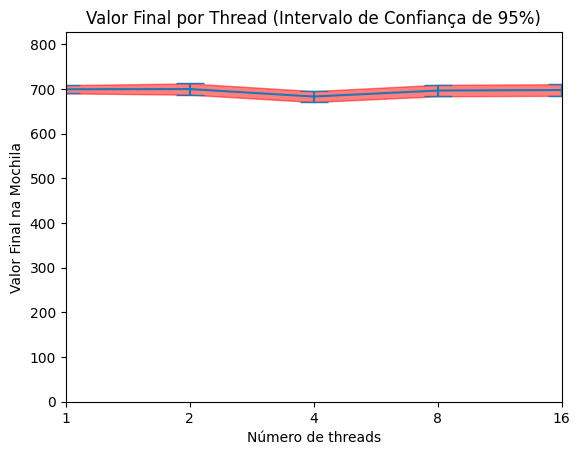

In [16]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_100)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_100)
execucoes_100 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_100)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_100)

Número de vizinhos explorados: 1000
Resultados:


psa1                   psa2                   psa4              \
   run_times final_value  run_times final_value  run_times final_value   
0  12.493814         804  10.673468         811  10.088367         814   
1  12.936853         830  10.429383         780  10.239532         818   
2  13.443513         809  10.878269         791   9.896110         817   
3  13.133958         821  10.946875         807  10.137882         834   
4  12.745322         807  10.914615         813  10.576617         831   
5  12.459068         780  10.795789         841  11.183124         808   
6  13.267338         784  10.316021         800  10.867780         807   
7  13.194921         813  10.870808         789  10.695814         789   
8  13.006050         815  10.537940         815  10.782006         797   
9  12.794346         816  10.681816         826  10.921947         799   

        psa8                  psa16              
   run_times final_value  run_times final_value  
0  11.491532         822  14.217463         827  
1  11.393401         811  14.163681         811  
2  11.248737         822  14.177085         826  
3  12.145509         861  14.430472         799  
4  11.319938         770  14.403483         805  
5  11.469903         816  14.376079         809  
6  11.036633         795  14.181836         819  
7  11.375494         832  14.302223         814  
8  11.509297         799  14.141219         829  
9  11.336603         796  14.808195         826

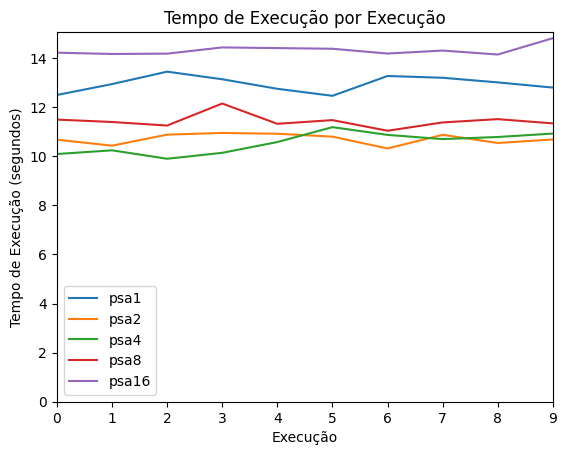

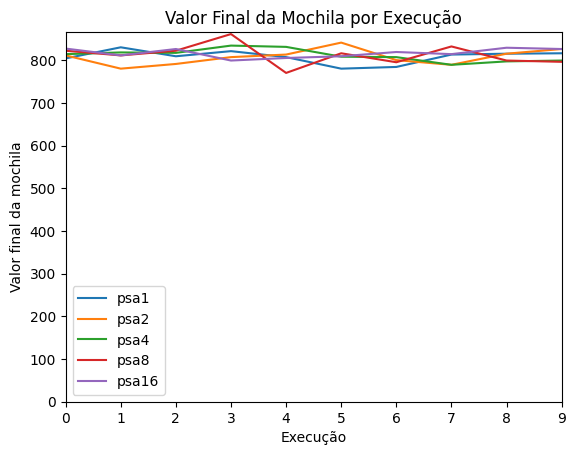

,psa1,psa2,psa4,psa8,psa16
media,12.947518,10.704498,10.538918,11.432705,14.320173
margem_erro,0.191697,0.127762,0.249594,0.168182,0.118802


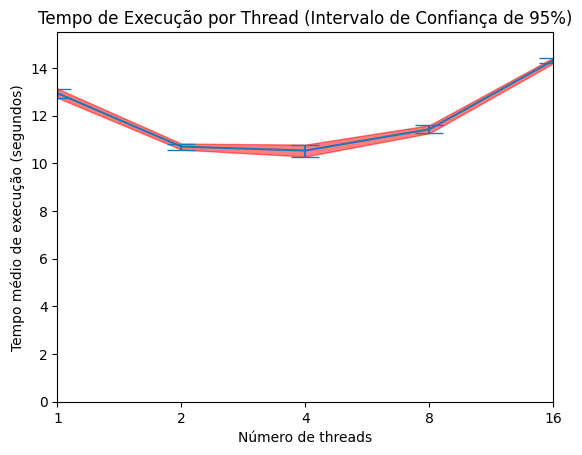

,psa1,psa2,psa4,psa8,psa16
media,807.900000,807.300000,811.400000,812.400000,816.500000
margem_erro,9.128004,10.717634,8.476632,14.528347,6.149842


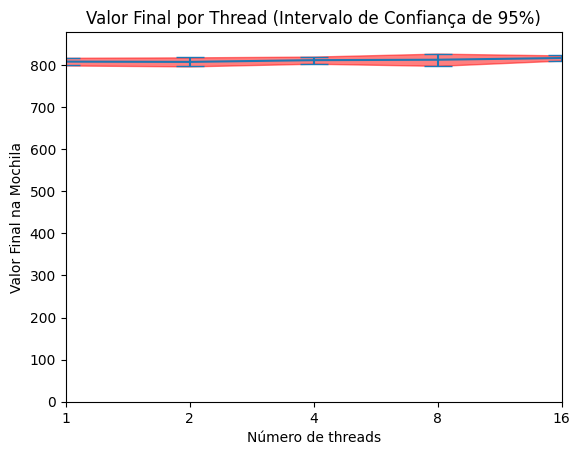

In [17]:
parametros_algoritmo = carregar_algoritmos(DIRETORIO_DATA_1000)
parametros_experimentacao = carregar_experimentacao(DIRETORIO_DATA_1000)
execucoes_1000 = carregar_execucoes(parametros_experimentacao,
                                   DIRETORIO_DATA_1000)

print("Número de vizinhos explorados:", parametros_algoritmo["numero_vizinhos_explorar"])
exibir_resultados_execucoes(execucoes_1000)